**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
  - [Récupération des données et requête SQL](#toc1_1_)    
- [Nettoyage des données](#toc2_)    
- [🚧 voir cohérence des tags en place](#toc3_)    
  - [Termes spécifiques](#toc3_1_)    
    - [Tags existants](#toc3_1_1_)    
    - [Langages de programmation de Wikipedia](#toc3_1_2_)    
    - [Ensemble complet des termes](#toc3_1_3_)    
- [XXXXXXXXXXXXXXXXXXXXXXXX](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
import numpy as np
import pandas as pd

# home made functions from the src folder
from src.scrap_and_clean import get_languages
from src.scrap_and_clean import clean_string
from src.scrap_and_clean import exclude_words
from src.scrap_and_clean import rm_ending_punctuation
from src.scrap_and_clean import clean_hashes

# ML
import nltk

## <a id='toc1_1_'></a>[Récupération des données et requête SQL](#toc0_)

[Requête disponible sur data.stackexchange.com](https://data.stackexchange.com/stackoverflow/query/1826330/top-50k-relevant-questions), en détails :

``` sql
-- select top 50k questions
SELECT TOP 50000 Title, Body, Tags, Score, AnswerCount, CreationDate, ViewCount
FROM Posts
WHERE PostTypeId = 1 -- (1 for questions)

--filter
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5
AND Score >= 10
AND AnswerCount >= 1

ORDER BY CreationDate DESC
```

Requête compromis fait entre qualité maximale et contraintes (≥ 5 tags)

- pour qualité, score ≥ 10 et >= 1 réponse (1 seule puisque selon les cas, si elle est de qualité, elle peut suffire à tous)
- => dates jusqu'à 2015, cohérent
- => reste à spectre large pour tout type de question
- => seules features indispensables & RGPD dans la requête
- ViewCount gardé mais pas utilisé comme filtre : relativement corrélé au score, mais pas totalement (différence d'usage entre les vues indexées par moteurs de recherche et les utilisateurs réguliers de SOF + entre la popularité d'un sujet et la niche)

Année passée : 204 rép avec len(tags) ≥5 et 970 sinon : trop peu !

si score > 5 : 4426 rép  
⇒ il faut du temps pour qu’elles soient à un score > 10  
⇒ choix de faire score ++ et dates jusqu’à 2015 pour qualité ++  

"mises en favori ou jugées pertinentes par les internautes" => favoris plus utilisés, filtre trop important : on prend le score

"Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais **pour les nouveaux utilisateurs**, il serait judicieux de suggérer quelques tags relatifs à la question posée"  

In [2]:
df_raw = pd.read_csv("data/2024-03-19 QueryResults.csv")

In [3]:
df_raw

,Title,Body,Tags,Score,AnswerCount,CreationDate,ViewCount
0,ITMS-91053: Missing API declaration - Privacy,<p>Why am I all of a suddent getting this on s...,<ios><app-store><plist><appstore-approval><pri...,24,7,2024-03-14 22:55:18,3092
1,Why is builtin sorted() slower for a list cont...,<p>I sorted four similar lists. List <code>d</...,<python><algorithm><performance><sorting><time...,28,2,2024-03-05 15:21:50,2699
2,std::shared_mutex::unlock_shared() blocks even...,<p>My team has encountered a deadlock that I s...,<c++><windows><multithreading><stl><shared-lock>,26,5,2024-03-01 23:09:59,1388
3,Did the rules for nullptr init of unique_ptr c...,<p>This code compiles with MSVC from VS 2022 i...,<c++><visual-c++><language-lawyer><unique-ptr>...,15,1,2024-02-22 11:29:42,490
4,Where is the order in which ELF relocations ar...,<p>Consider the following two files on a Linux...,<c++><elf><dynamic-linking><abi><relocation>,16,1,2024-02-19 21:42:03,1746
...,...,...,...,...,...,...,...
49995,Reverse engineer assembly code to c code,<p>I think this is actually a pretty simple pr...,<c><assembly><reverse-engineering><x86-64><con...,10,3,2015-02-12 23:51:30,6771
49996,Combining random forest models in scikit learn,"<p>I have two RandomForestClassifier models, a...",<python><python-2.7><scikit-learn><classificat...,21,2,2015-02-12 23:11:56,13071
49997,How can I get the primary color from my app th...,"<p>In my Android java code, how can I referenc...",<android><android-xml><android-theme><android-...,28,2,2015-02-12 22:58:22,20107
49998,CORS settings for IIS 7.5,<p>How can I convert the following code for us...,<asp.net><iis><cors><web-config><iis-7.5>,12,2,2015-02-12 21:53:34,56289


# <a id='toc2_'></a>[Nettoyage des données](#toc0_)

utile de préciser que l'encodage par défaut de la méthode read_csv() est 'utf-8', de même que le HTMLParser utilisé pour récupérer les langages de programmation ci-après

In [4]:
# keep useful features
df = df_raw.copy()[["Title", "Body", "Tags"]]

In [5]:
# change Tags string to list
df["Tags"] = df["Tags"].apply(lambda x: x[1:-1].split("><"))

## <a id='toc3_1_'></a>[Termes spécifiques](#toc0_)

🚧 voir utilité => pour le tokenizer ?

🚧 [HTML Parser](https://stackoverflow.com/questions/59660495/python-html-extract-text-into-list) : (cf. [question SoF](https://stackoverflow.com/questions/59660495/python-html-extract-text-into-list))  
[RegEx JL](https://www.notion.so/julmat/RegEx-expressions-r-guli-res-70fbbcb177ee476ba9a5ae011d14fe6f) & [RegEx 101](https://regex101.com/?flavor=python&flags=gm)

# <a id='toc3_'></a>[🚧 voir cohérence des tags en place](#toc0_)

### <a id='toc3_1_1_'></a>[Tags existants](#toc0_)

In [6]:
def add_tags(x):
    for e in x:
        tags.add(e)


# use a set to avoid duplicates
tags = set()
# loop over the tags and add them to the set
df["Tags"].apply(lambda x: add_tags(x))
# back to a list
tags = list(tags)

print(f"Found {len(tags)} existing tags")

Found 16975 existing tags


In [7]:
print(tags[7990:8010])

['nosuchmethoderror', 'spring-oauth2', 'har', 'gnupg', 'jvm-crash', 'omnipay', 'rust-decl-macros', 'version', 'blurry', 'moto', 'avaudiorecorder', 'initialization-order', 'cloudant', 'prefix', 'jack-toolchain', 'forward-indexing', 'request-timed-out', 'laravel-horizon', 'elasticsearch-net', 'shaderlab']


### <a id='toc3_1_2_'></a>[Langages de programmation de Wikipedia](#toc0_)

Sur StackOverFlow, les noms de langages informatiques dans les dialogues sont fréquents.  
Non seulement ils ont des syntaxes spécifiques (.QL, C++, S, C#...) facilement éliminées par des traitements de caractères spécifiques, mais ils sont également représentatifs du sujet et font souvent partie des tags.

In [8]:
prog_lang = get_languages()
print(f"Found {len(prog_lang)} programming languages on Wikipedia")

Found 692 programming languages on Wikipedia


### <a id='toc3_1_3_'></a>[Ensemble complet des termes](#toc0_)

In [9]:
# concatenate all specific terms
spec_terms = prog_lang + tags
print(f"Total: {len(spec_terms)} specific terms")

Total: 17667 specific terms


# <a id='toc4_'></a>[XXXXXXXXXXXXXXXXXXXXXXXX](#toc0_)

In [10]:
df["Body"] = df["Body"].apply(clean_string)
df["Title"] = df["Title"].apply(clean_string)

In [11]:
df

,Title,Body,Tags
0,itms- : missing api declaration - privacy,why am i all of a suddent getting this on succ...,"[ios, app-store, plist, appstore-approval, pri..."
1,why is builtin sorted() slower for a list cont...,i sorted four similar lists. list consistently...,"[python, algorithm, performance, sorting, time..."
2,std::shared_mutex::unlock_shared() blocks even...,my team has encountered a deadlock that i susp...,"[c++, windows, multithreading, stl, shared-lock]"
3,did the rules for nullptr init of unique_ptr c...,this code compiles with msvc from vs in c++ mo...,"[c++, visual-c++, language-lawyer, unique-ptr,..."
4,where is the order in which elf relocations ar...,consider the following two files on a linux sy...,"[c++, elf, dynamic-linking, abi, relocation]"
...,...,...,...
49995,reverse engineer assembly code to c code,i think this is actually a pretty simple probl...,"[c, assembly, reverse-engineering, x86-64, con..."
49996,combining random forest models in scikit learn,"i have two randomforestclassifier models, and ...","[python, python-2.7, scikit-learn, classificat..."
49997,how can i get the primary color from my app th...,"in my android java code, how can i reference t...","[android, android-xml, android-theme, android-..."
49998,cors settings for iis .,how can i convert the following code for use i...,"[asp.net, iis, cors, web-config, iis-7.5]"


🚧 pour tests

In [12]:
id = 3
title = df["Title"][id]
body = df["Body"][id]

# Vocabulaire

⚠️ le word_tokenize de NLTK sépare "#" du mot précédent, ce qui est gênant puisqu'utilisé pour plusieurs langages informatiques, très susceptibles d'être utilisés comme tags  

une technique consiste à utiliser la bibliothèque Wulti-Word Tokenizer, mais elle déforme la sortie : ("C", "#") → "C_#"  

le plus cohérent est de vérifier qu'un langage informatique avec cette configuration et de procéder à l'union des mots dans ce seul cas  

In [13]:
SENTENCE = "This is a C++ sentence : using coma, m4ny 456 words and 2.5 sentences. C#, q#, and .qt are also present, such as a+ algol a.net a-0 system or @formula x10 z++ t-sql seed7 s3 sa-c s/sl s-plus."

tokens = nltk.word_tokenize(SENTENCE.lower())

print(tokens)

['this', 'is', 'a', 'c++', 'sentence', ':', 'using', 'coma', ',', 'm4ny', '456', 'words', 'and', '2.5', 'sentences', '.', 'c', '#', ',', 'q', '#', ',', 'and', '.qt', 'are', 'also', 'present', ',', 'such', 'as', 'a+', 'algol', 'a.net', 'a-0', 'system', 'or', '@', 'formula', 'x10', 'z++', 't-sql', 'seed7', 's3', 'sa-c', 's/sl', 's-plus', '.']


## Titres

In [14]:
bow_title_raw = df["Title"].apply(
    lambda x: clean_hashes(nltk.word_tokenize(x), prog_lang)
)

In [15]:
bow_title = []
bow_title_raw.apply(lambda x: bow_title.extend(x))
print(len(bow_title), "tokens:\n", bow_title[252000:252020])

520562 tokens:
 ['shells', 'ignore', 'sigint', 'and', 'sigquit', 'in', 'backgrounded', 'processes', '?', 'control', 'degree', 'of', 'parallelism', 'with', 'std', ':', ':async', 'nuget', 'does', "n't"]


## Corps

In [16]:
bow_body_raw = df["Body"].apply(
    lambda x: clean_hashes(nltk.word_tokenize(x), prog_lang)
)

In [17]:
bow_body = []
bow_body_raw.apply(lambda x: bow_body.extend(x))
print(len(bow_body), "tokens:\n", bow_body[252000:252020])

7015498 tokens:
 ["'", 'where', 'primary', 'key', 'is', 'book_name', ':', 'i', 'am', 'trying', 'to', 'create', 'a', 'second', 'table', 'named', "'name", "'", 'where', 'name']


# 🚧 DEBUG

In [18]:
print(title, "\n\n", body)

did the rules for nullptr init of unique_ptr change in c++ ? 

 this code compiles with msvc from vs in c++ mode. it failes in c++ mode. () current versions of gcc and clang accept this code in c++ mode. live code on compiler explorer msvc in c++ mode: microsoft answerd me (not public available yet) that the new behavior is due to in c++ mode and they are just following the standard with this. is this corrent? are gcc and clang are wrong to accept this code in c++ mode? i'll add some more explanation to what happens here, because some of the comments indicate that this is not obvious. the constructor of is called here. it doesn't call the constructor of the incomplete type , because it is initialized with a . this part seams to be fine for msvc in c++ mode. the destructor of is not called here. it is called from the destructor of which is defined in another source code file, where is a complete type. this works with gcc and clang. it also works with msvc in c++ mode. in c++ mode msvc c

In [19]:
print(bow_title_raw[id])

['did', 'the', 'rules', 'for', 'nullptr', 'init', 'of', 'unique_ptr', 'change', 'in', 'c++', '?']


In [20]:
print(bow_body_raw[id])

['this', 'code', 'compiles', 'with', 'msvc', 'from', 'vs', 'in', 'c++', 'mode', '.', 'it', 'failes', 'in', 'c++', 'mode', '.', '(', ')', 'current', 'versions', 'of', 'gcc', 'and', 'clang', 'accept', 'this', 'code', 'in', 'c++', 'mode', '.', 'live', 'code', 'on', 'compiler', 'explorer', 'msvc', 'in', 'c++', 'mode', ':', 'microsoft', 'answerd', 'me', '(', 'not', 'public', 'available', 'yet', ')', 'that', 'the', 'new', 'behavior', 'is', 'due', 'to', 'in', 'c++', 'mode', 'and', 'they', 'are', 'just', 'following', 'the', 'standard', 'with', 'this', '.', 'is', 'this', 'corrent', '?', 'are', 'gcc', 'and', 'clang', 'are', 'wrong', 'to', 'accept', 'this', 'code', 'in', 'c++', 'mode', '?', 'i', "'ll", 'add', 'some', 'more', 'explanation', 'to', 'what', 'happens', 'here', ',', 'because', 'some', 'of', 'the', 'comments', 'indicate', 'that', 'this', 'is', 'not', 'obvious', '.', 'the', 'constructor', 'of', 'is', 'called', 'here', '.', 'it', 'does', "n't", 'call', 'the', 'constructor', 'of', 'the', '

# Tests BOW

In [21]:
entities = nltk.chunk.ne_chunk(bow_title)

LookupError: 
**********************************************************************
  Resource [93mmaxent_ne_chunker[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('maxent_ne_chunker')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mchunkers/maxent_ne_chunker/PY3/english_ace_multiclass.pickle[0m

  Searched in:
    - '/home/vscode/nltk_data'
    - '/home/vscode/.env/nltk_data'
    - '/home/vscode/.env/share/nltk_data'
    - '/home/vscode/.env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [ ]:
# bow_title = clean_hashes(bow_title_raw, list(prog_lang))


['shells', 'ignore', 'sigint', 'and', 'sigquit', 'in', 'backgrounded', 'processes', '?', 'control', 'degree', 'of', 'parallelism', 'with', 'std', ':', ':async', 'nuget', 'does', "n't"]


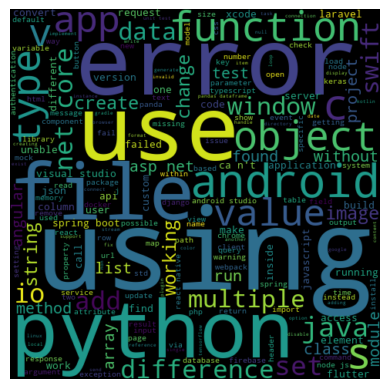

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join the different processed titles together.
long_string = ' '.join(bow_title)

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(long_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()